Используемые источники:

* [Первая глава диссертации об общих подходах к прогнозированию и оценки uplift](http://www.maths.ed.ac.uk/~mthdat25/uplift/MesallesNaranjoOscar-1)
* [Статья о подходах к прогнозированию ulpift](http://people.cs.pitt.edu/~milos/icml_clinicaldata_2012/Papers/Oral_Jaroszewitz_ICML_Clinical_2012.pdf)
* [Статья, в которой неплохо описаны способы оценок uplift](http://stochasticsolutions.com/pdf/sig-based-up-trees.pdf)
* [Репозиторий на github с некоторыми подходами к прогнозированию и оценке uplift](https://github.com/PGuti/Uplift)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.image as image

import sys
sys.path.append('./')
from utils import Dummyfier, prepare, evaluate_clf, uplift

from IPython.core.debugger import set_trace

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('./train_data/train_dataset.csv', sep='>', na_values='<null>', 
                 parse_dates=['START_DATE', 'LAST_CARD_STATUS_DT', 'LAST_CONTR_STATUS_DT', 'BIRTH_DATE'])
print('Dataset size: ', df.shape)
df.head(2)

Dataset size:  (114720, 215)


,CONTRACT_REF,CLIENT_ID,CONTROL_GROUP_FLG,START_DATE,TARGET,11_AddrCity2,11_AddrCountry,12_AddrCity2,12_AddrCountry,13_AddrCity2,...,TXN_TP_POS_N_180,TXN_TP_POS_N_31,TXN_TP_POS_N_90,TXN_TP_POS_SUM_180,TXN_TP_POS_SUM_31,TXN_TP_POS_SUM_90,TXN_TP_Purposeful credit_MAX_180,TXN_TP_Purposeful credit_MEAN_180,TXN_TP_Purposeful credit_N_180,TXN_TP_Purposeful credit_SUM_180
0,273-P-99431598,105098373,N,2017-01-23,1,ГОРЯЧИЙКЛЮЧ,RU,ГОРЯЧИЙКЛЮЧ,RU,КАМЫШИН,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,274-P-23967129,101763714,N,2017-04-08,1,МУРМАНСК,RU,МУРМАНСК,RU,АХТУБИНСК,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df['TARGET'].value_counts(normalize=True)

0    0.955483
1    0.044517
Name: TARGET, dtype: float64

In [32]:
df[df['CONTROL_GROUP_FLG']=='Y'].

(17273, 216)

In [33]:
17273 * 0.026921

465.006433

In [5]:
df.groupby('CONTROL_GROUP_FLG').mean()[['TARGET']]

,TARGET
CONTROL_GROUP_FLG,
N,0.047636
Y,0.026921


# 1 Построение одной модели для тестовой и контрольной групп

In [6]:
Xy_train, Xy_val = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['TARGET'])

dummy = [u'CL_FAM_ST', u'CL_OFF_POS', u'CL_OWN_TYPE', u'LAST_CARD_STATUS', 'CL_ESTATE_TYPE', 
         'CL_INDUSTR', 'CL_SOC_ST', 'ZODIAC']
d = Dummyfier(dummy, drop_old=True)

Xy_train = prepare(Xy_train)
Xy_train = d.fit_transform(Xy_train)

na_cols_train = Xy_train.isna().any()
na_cols_train = na_cols_train[na_cols_train==True].index.tolist()
Xy_train = Xy_train.fillna(value=Xy_train[na_cols_train].mean())

Xy_val = prepare(Xy_val)
Xy_val = d.transform(Xy_val)

na_cols_val = Xy_val.isna().any()
na_cols_val = na_cols_val[na_cols_val==True].index.tolist()
Xy_val = Xy_val.fillna(value=Xy_val[na_cols_val].mean())

y_train, y_val = Xy_train['TARGET'].values.flatten(), Xy_val['TARGET'].values.flatten()

identity = ['CONTRACT_REF', 'CLIENT_ID', 'SCENARIO_NAME_UNI', 'START_DATE']
X_train, X_val = Xy_train.drop(['TARGET'] + identity, axis=1), Xy_val.drop(['TARGET'] + identity, axis=1)

C:\Users\SHevchenkoM\Program_files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


                 train     valid
ROC AUC       0.811373  0.811337
Av Precision  0.183269  0.157046
logloss       0.153513  0.153915
Accuracy      0.930559  0.928173
Precision     0.220073  0.192948
Precision@10  0.172079  0.160488
Recall        0.220020  0.192948
F1            0.220047  0.192948
F0.5          0.220063  0.192948
F2            0.220030  0.192948


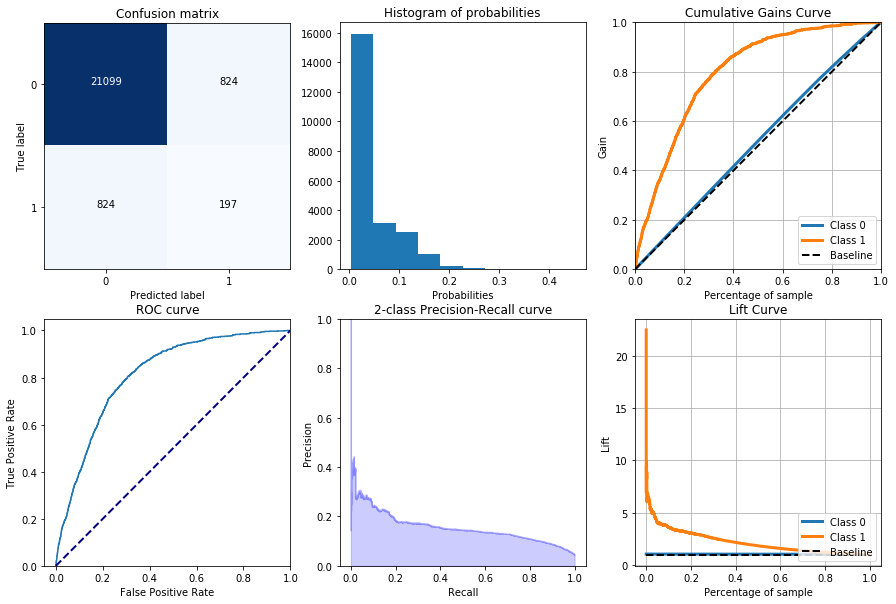

Wall time: 15.2 s


In [7]:
%%time
import xgboost as xgb

boost = xgb.XGBClassifier()

boost_model, _ = evaluate_clf(boost, X_train, y_train, X_val, y_val)

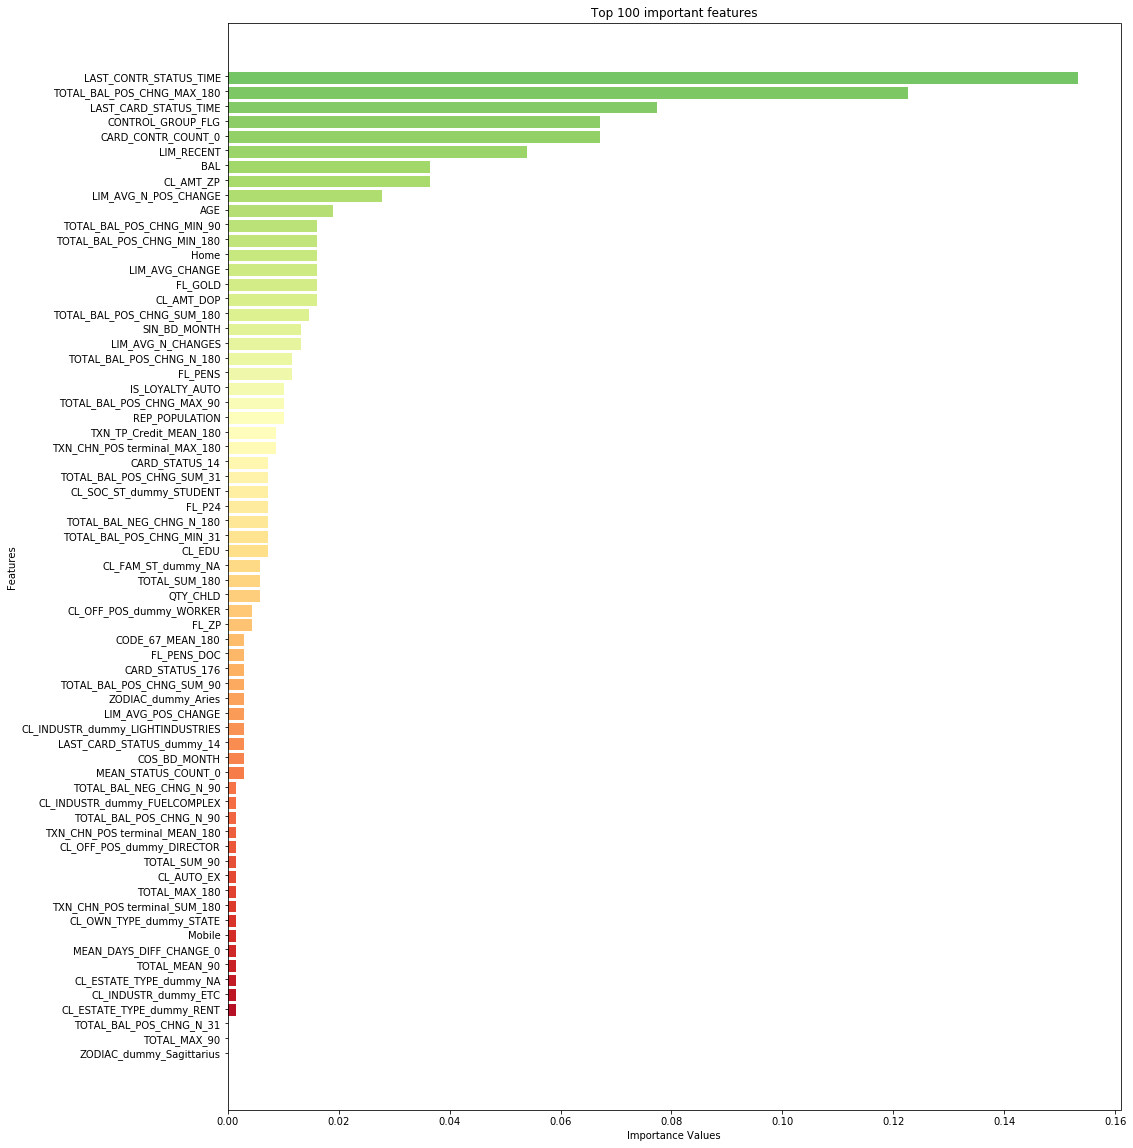

In [8]:
importances = pd.DataFrame(data={
    'features': X_train.columns,
    'fscore': boost_model.feature_importances_
})

# сортируем по абсолютному значению поля fscore
importances = importances.reindex(importances.fscore.abs().sort_values().index)

f_names, f_values = importances['features'].tail(100), importances['fscore'].tail(100)
## all columns from [st_idx : end_idx] will be plotted
## the higher the index, the more important the feature
st_idx = int(len(f_names) / 3); end_idx = int(len(f_names) / 1);

fig = plt.figure(figsize=(16, 20))
plt.barh(np.arange(len(f_names[st_idx : end_idx])), f_values[st_idx : end_idx],
         color=[cm.RdYlGn(i * 3) for i in range(len(f_names[st_idx : end_idx]))])
fig.axes[0].set_yticklabels(f_names[st_idx : end_idx])
fig.axes[0].set_yticks(np.arange(len(f_names[st_idx : end_idx])) + 0.1)
fig.axes[0].set_xlabel('Importance Values')
fig.axes[0].set_ylabel('Features')
fig.axes[0].set_label('Feature Importances')

plt.title('Top 100 important features')
plt.show()

## Оценим UPLIFT

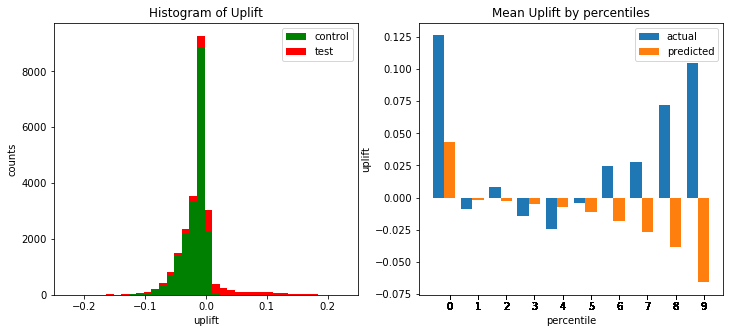

In [9]:
# Клиенты с реальными значениями флага_кг
evaluate1 =  X_val.copy()
evaluate1['TARGET'] = y_val
evaluate1['real'] = True

# Клиенты с инверсионными значениями флага_кг
evaluate2 = X_val.copy()
evaluate2['CONTROL_GROUP_FLG'] = 1 - evaluate2['CONTROL_GROUP_FLG']
evaluate2['real'] = False

for_model = pd.concat([evaluate1, evaluate2])
del evaluate1, evaluate2

for_model = for_model.reset_index().sort_values(['index', 'CONTROL_GROUP_FLG'], ascending=[False, True]).set_index('index')

for_model['not_sent'] = boost_model.predict_proba(for_model[X_val.columns])[:, 1]
for_model['sent'] = for_model['not_sent'].shift(-1)
for_model['uplift'] = for_model['sent'] - for_model['not_sent']
# оценим uplift
evaluate =Xy_val.copy()
evaluate['not_sent'] = for_model[for_model['real']==True]['not_sent']
evaluate['sent'] = for_model[for_model['real']==True]['sent']
evaluate['uplift'] = for_model[for_model['real']==True]['uplift']

evaluate['predict'] = np.floor(evaluate.uplift.rank(method='first', ascending = False) /\
                                            (evaluate.shape[0]+1) * 10)

eval_actual = pd.crosstab(index=evaluate['predict'].astype(int), columns=evaluate['CONTROL_GROUP_FLG'], 
            values=evaluate['TARGET'], aggfunc='mean')
eval_actual['uplift'] = eval_actual[0] - eval_actual[1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].title.set_text('Histogram of Uplift')
axes[0].hist([evaluate[evaluate['CONTROL_GROUP_FLG']==0]['uplift'],
          evaluate[evaluate['CONTROL_GROUP_FLG']==1]['uplift']],
         stacked=True, label=['control', 'test'], bins=50, color=['g', 'r'])

axes[0].set_xlabel('uplift')
axes[0].set_ylabel('counts')
axes[0].set_xlim([-0.25, 0.25])
axes[0].legend()


axes[1].bar(eval_actual.index-0.4, eval_actual['uplift'], label='actual', width = 0.4)
axes[1].bar(evaluate.groupby('predict').mean().index, 
        evaluate.groupby('predict').mean()['uplift'], label='predicted', width=0.4)
axes[1].set_xticks(evaluate['predict'])
axes[1].set_xlabel('percentile')
axes[1].set_ylabel('uplift')
axes[1].legend()
axes[1].title.set_text('Mean Uplift by percentiles')

In [10]:
eval_actual

CONTROL_GROUP_FLG,0,1,uplift
predict,,,
0,0.152778,0.026553,0.126225
1,0.003613,0.012500,-0.008887
2,0.008186,0.000000,0.008186
3,0.007713,0.022222,-0.014509
4,0.012797,0.037383,-0.024586
5,0.026777,0.031250,-0.004473
6,0.048015,0.023256,0.024759
7,0.073227,0.045872,0.027355
8,0.107294,0.035294,0.072000


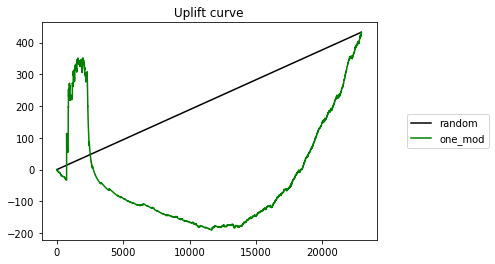

In [11]:
one_mod_uc = uplift(evaluate, 'CONTROL_GROUP_FLG', 'TARGET', 'uplift')

rd_uc = (evaluate[evaluate['CONTROL_GROUP_FLG']==0]['TARGET'].sum() / evaluate[evaluate['CONTROL_GROUP_FLG']==0].shape[0]
        - evaluate[evaluate['CONTROL_GROUP_FLG']==1]['TARGET'].sum() / evaluate[evaluate['CONTROL_GROUP_FLG']==1].shape[0])
rd = np.arange(evaluate.shape[0]) * rd_uc

plt.title('Uplift curve')
plt.plot(np.arange(evaluate.shape[0]), rd, color = 'k', label = 'random')
plt.plot(np.arange(evaluate.shape[0]), one_mod_uc, color = 'g', label = 'one_mod')
plt.legend(bbox_to_anchor=(1.35, 0.6))

# 2 Построение двух моделей

In [12]:
X_train_c = Xy_train[Xy_train['CONTROL_GROUP_FLG']==1].drop(['TARGET', 'CONTROL_GROUP_FLG'] + identity, axis=1)
y_train_c = Xy_train[Xy_train['CONTROL_GROUP_FLG']==1]['TARGET'].values.flatten()
X_val_c = Xy_val[Xy_val['CONTROL_GROUP_FLG']==1].drop(['TARGET', 'CONTROL_GROUP_FLG'] + identity, axis=1)
y_val_c = Xy_val[Xy_val['CONTROL_GROUP_FLG']==1]['TARGET'].values.flatten()

X_train_t = Xy_train[Xy_train['CONTROL_GROUP_FLG']==0].drop(['TARGET', 'CONTROL_GROUP_FLG'] + identity, axis=1)
y_train_t = Xy_train[Xy_train['CONTROL_GROUP_FLG']==0]['TARGET'].values.flatten()
X_val_t = Xy_val[Xy_val['CONTROL_GROUP_FLG']==0].drop(['TARGET', 'CONTROL_GROUP_FLG'] + identity, axis=1)
y_val_t = Xy_val[Xy_val['CONTROL_GROUP_FLG']==0]['TARGET'].values.flatten()

                 train     valid
ROC AUC       0.822118  0.831339
Av Precision  0.194696  0.129657
logloss       0.145246  0.150527
Accuracy      0.959275  0.954794
Precision     0.232240  0.191489
Precision@10  0.147907  0.155629
Recall        0.232240  0.181818
F1            0.232240  0.186528
F0.5          0.232240  0.189474
F2            0.232240  0.183673


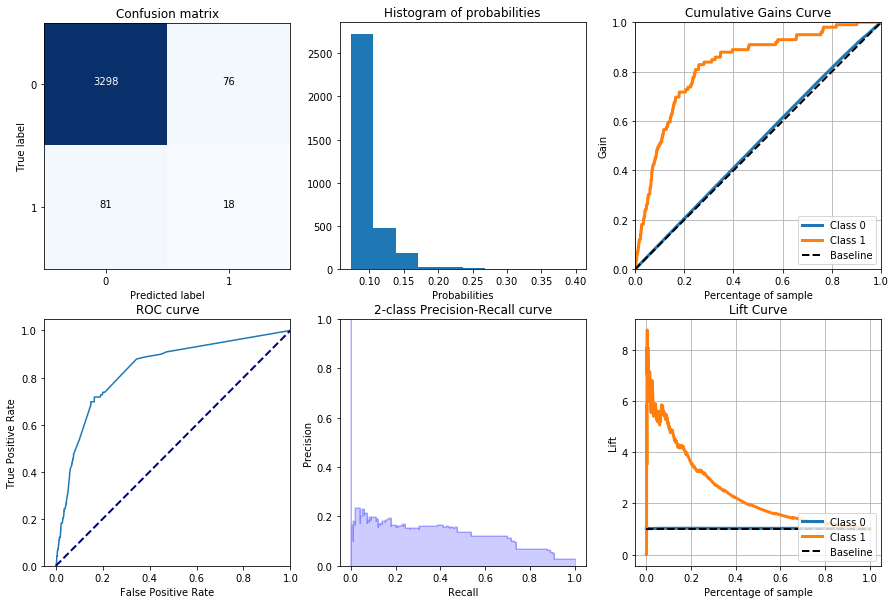

In [13]:
boost_c = xgb.XGBClassifier(learning_rate=0.02)

boost_model_c, c_prob = evaluate_clf(boost_c, X_train_c, y_train_c, X_val_c, y_val_c)

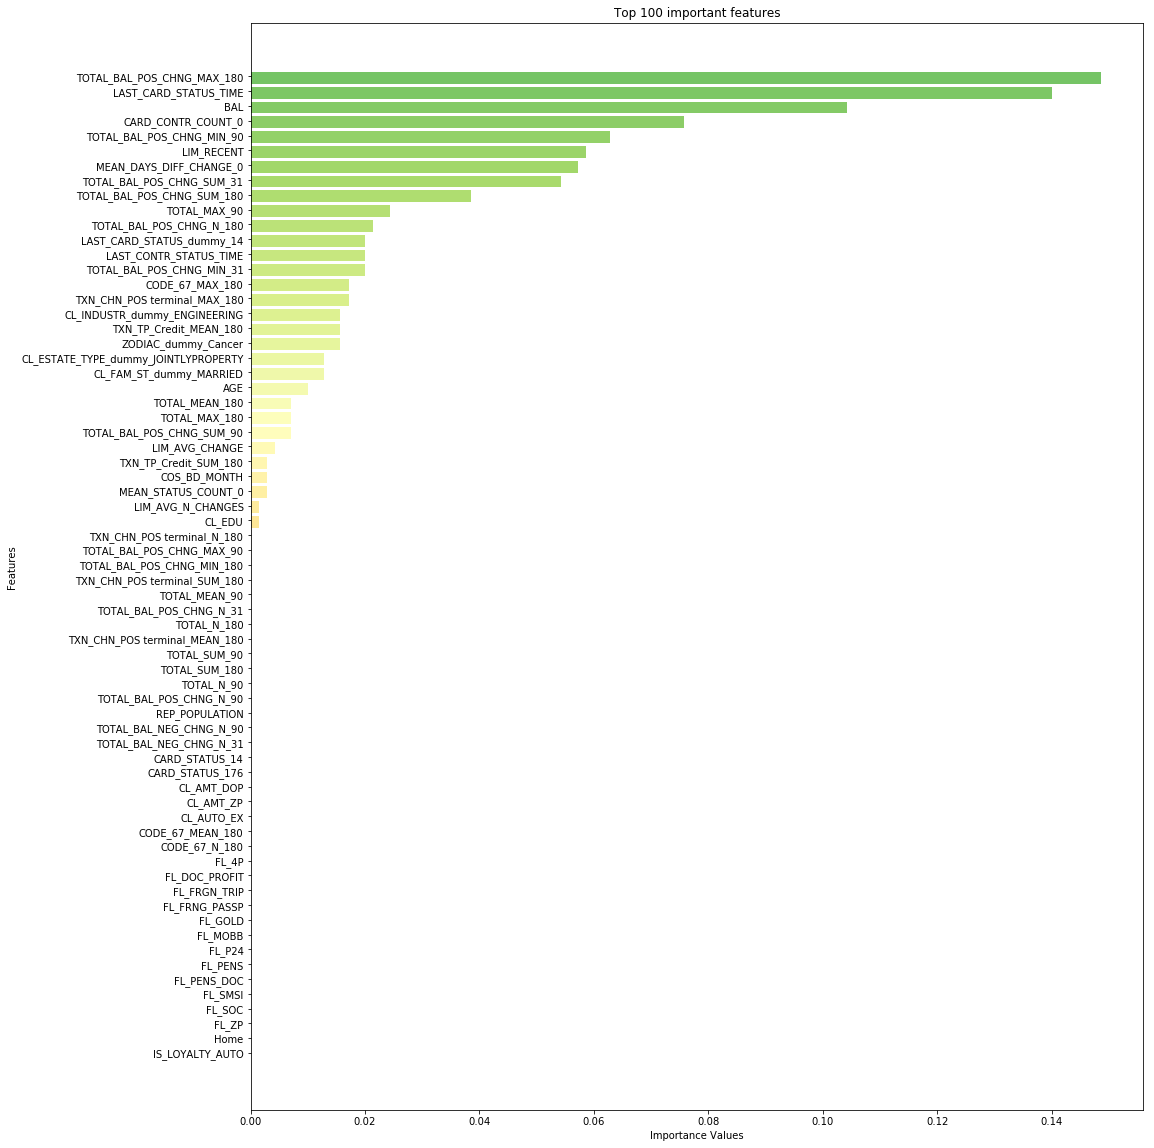

In [14]:
importances = pd.DataFrame(data={
    'features': X_train_c.columns,
    'fscore': boost_model_c.feature_importances_
})

# сортируем по абсолютному значению поля fscore
importances = importances.reindex(importances.fscore.abs().sort_values().index)

f_names, f_values = importances['features'].tail(100), importances['fscore'].tail(100)
## all columns from [st_idx : end_idx] will be plotted
## the higher the index, the more important the feature
st_idx = int(len(f_names) / 3); end_idx = int(len(f_names) / 1);

fig = plt.figure(figsize=(16, 20))
plt.barh(np.arange(len(f_names[st_idx : end_idx])), f_values[st_idx : end_idx],
         color=[cm.RdYlGn(i * 3) for i in range(len(f_names[st_idx : end_idx]))])
fig.axes[0].set_yticklabels(f_names[st_idx : end_idx])
fig.axes[0].set_yticks(np.arange(len(f_names[st_idx : end_idx])) + 0.1)
fig.axes[0].set_xlabel('Importance Values')
fig.axes[0].set_ylabel('Features')
fig.axes[0].set_label('Feature Importances')

plt.title('Top 100 important features')
plt.show()

                 train     valid
ROC AUC       0.764684  0.768990
Av Precision  0.142857  0.132054
logloss       0.202291  0.201538
Accuracy      0.921514  0.920497
Precision     0.180511  0.162716
Precision@10  0.154141  0.147938
Recall        0.182258  0.163774
F1            0.181380  0.163243
F0.5          0.180858  0.162926
F2            0.181906  0.163562


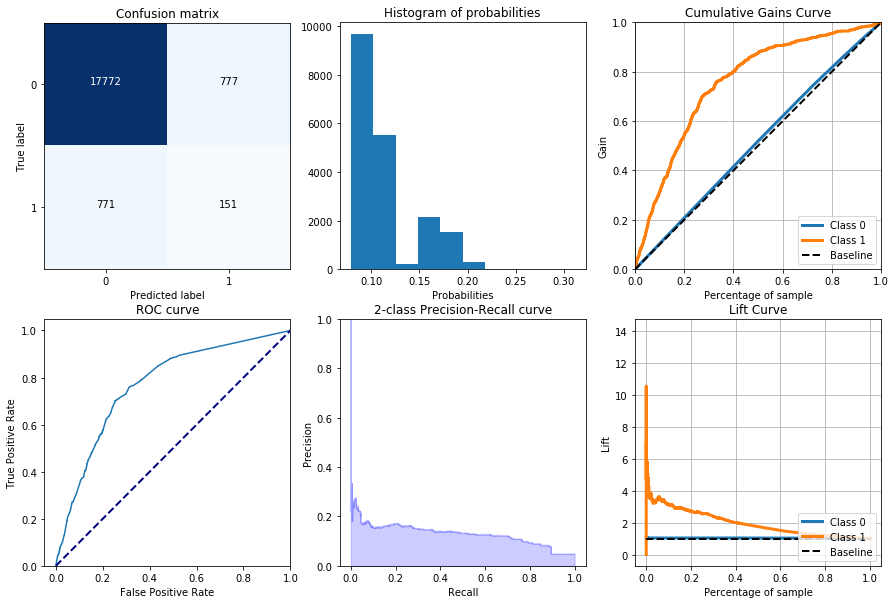

In [15]:
boost_t = xgb.XGBClassifier(learning_rate=0.02)

boost_model_t, t_prob = evaluate_clf(boost_t, X_train_t, y_train_t, X_val_t, y_val_t)

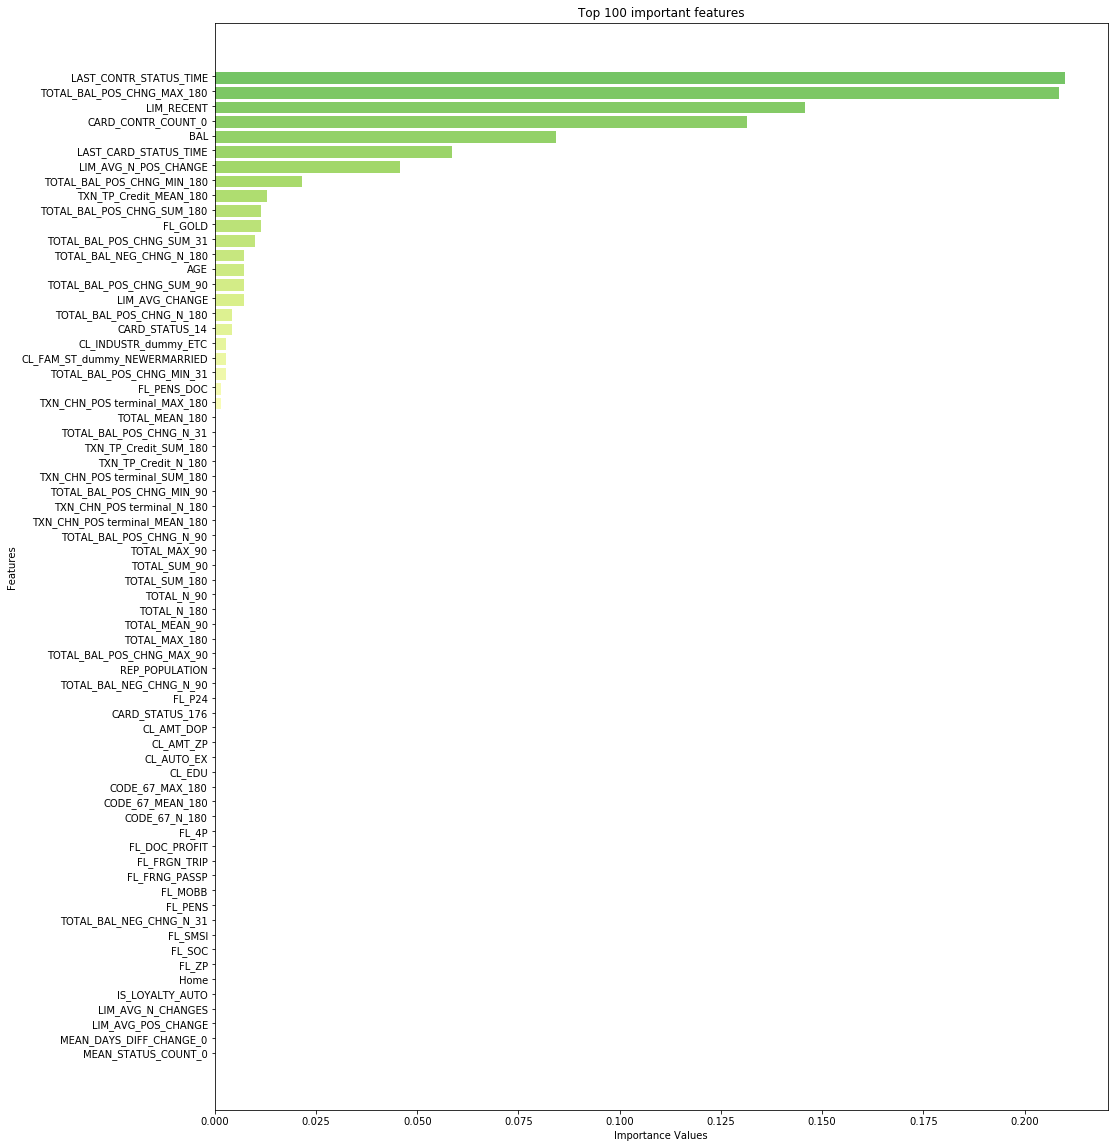

In [16]:
importances = pd.DataFrame(data={
    'features': X_train_t.columns,
    'fscore': boost_model_t.feature_importances_
})

# сортируем по абсолютному значению поля fscore
importances = importances.reindex(importances.fscore.abs().sort_values().index)

f_names, f_values = importances['features'].tail(100), importances['fscore'].tail(100)
## all columns from [st_idx : end_idx] will be plotted
## the higher the index, the more important the feature
st_idx = int(len(f_names) / 3); end_idx = int(len(f_names) / 1);

fig = plt.figure(figsize=(16, 20))
plt.barh(np.arange(len(f_names[st_idx : end_idx])), f_values[st_idx : end_idx],
         color=[cm.RdYlGn(i * 3) for i in range(len(f_names[st_idx : end_idx]))])
fig.axes[0].set_yticklabels(f_names[st_idx : end_idx])
fig.axes[0].set_yticks(np.arange(len(f_names[st_idx : end_idx])) + 0.1)
fig.axes[0].set_xlabel('Importance Values')
fig.axes[0].set_ylabel('Features')
fig.axes[0].set_label('Feature Importances')

plt.title('Top 100 important features')
plt.show()

## Оценим UPLIFT

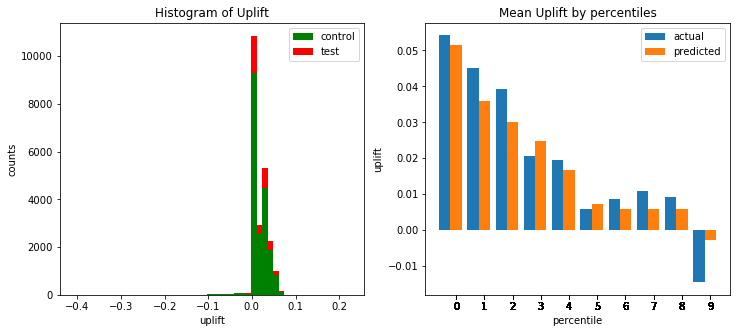

In [17]:
evaluate['sent'] = boost_model_t.predict_proba(X_val.drop(['CONTROL_GROUP_FLG'], axis=1))[:, 1]
evaluate['not_sent'] = boost_model_c.predict_proba(X_val.drop(['CONTROL_GROUP_FLG'], axis=1))[:, 1]
evaluate['uplift'] = evaluate['sent'] - evaluate['not_sent']

evaluate['predict'] = np.floor(evaluate.uplift.rank(method='first', ascending = False) /\
                                            (evaluate.shape[0]+1) * 10)

eval_actual = pd.crosstab(index=evaluate['predict'].astype(int), columns=evaluate['CONTROL_GROUP_FLG'], 
            values=evaluate['TARGET'], aggfunc='mean')
eval_actual['uplift'] = eval_actual[0] - eval_actual[1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].title.set_text('Histogram of Uplift')
axes[0].hist([evaluate[evaluate['CONTROL_GROUP_FLG']==0]['uplift'],
          evaluate[evaluate['CONTROL_GROUP_FLG']==1]['uplift']],
         stacked=True, label=['control', 'test'], bins=50, color=['g', 'r'])
axes[0].set_xlabel('uplift')
axes[0].set_ylabel('counts')
axes[0].legend()


axes[1].bar(eval_actual.index-0.4, eval_actual['uplift'], label='actual', width = 0.4)
axes[1].bar(evaluate.groupby('predict').mean().index, 
        evaluate.groupby('predict').mean()['uplift'], label='predicted', width=0.4)
axes[1].set_xticks(evaluate['predict'])
axes[1].set_xlabel('percentile')
axes[1].set_ylabel('uplift')
axes[1].legend()
axes[1].title.set_text('Mean Uplift by percentiles')

In [18]:
eval_actual

CONTROL_GROUP_FLG,0,1,uplift
predict,,,
0,0.136221,0.082011,0.054211
1,0.101510,0.056300,0.045209
2,0.055208,0.016000,0.039208
3,0.055266,0.034574,0.020691
4,0.041498,0.021944,0.019554
5,0.020072,0.014245,0.005827
6,0.011705,0.003030,0.008675
7,0.010808,0.000000,0.010808
8,0.009119,0.000000,0.009119


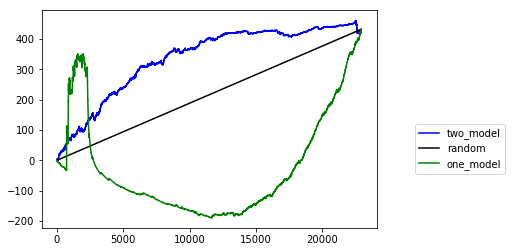

In [19]:
two_mod_uc = uplift(evaluate, 'CONTROL_GROUP_FLG', 'TARGET', 'uplift')

plt.plot(np.arange(evaluate.shape[0]), two_mod_uc, color = 'b', label = 'two_model')
plt.plot(np.arange(evaluate.shape[0]), rd, color = 'k', label = 'random')
plt.plot(np.arange(evaluate.shape[0]), one_mod_uc, color = 'g', label = 'one_model')
plt.legend(bbox_to_anchor=(1.4, 0.5))

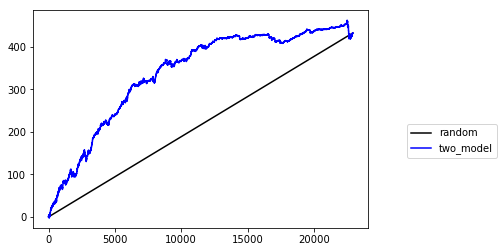

In [20]:
plt.plot(np.arange(evaluate.shape[0]),rd, color = 'k', label = 'random')
plt.plot(np.arange(evaluate.shape[0]), two_mod_uc, color = 'b', label = 'two_model')
plt.legend(bbox_to_anchor=(1.4, 0.5))

In [30]:
two_mod_uc[:5000].mean()

134.60160424399652

# 3 Подход "Class Modification"

In [21]:
df['modified_outcome'] = df['TARGET'] * (1 - df['CONTROL_GROUP_FLG'].map({'N': 0, 'Y': 1})) \
                                 + (1-df['TARGET']) * df['CONTROL_GROUP_FLG'].map({'N': 0, 'Y': 1})

Данный подход требует, чтобы объем контрольной и тестовой групп был одинаков. Поэтому для достижения результатов произведем undersamplimg:

In [22]:
df_modify = pd.concat([
    df[df['CONTROL_GROUP_FLG']=='N'].sample(n=df[df['CONTROL_GROUP_FLG']=='Y'].shape[0],
                                        random_state=555),
    df[df['CONTROL_GROUP_FLG']=='Y']
])

In [23]:
Xy_train, Xy_val = train_test_split(
    df_modify, 
    test_size=0.2, 
    random_state=42, stratify=df_modify['modified_outcome'])

d = Dummyfier(dummy, drop_old=True)

scaler = StandardScaler()

Xy_train = prepare(Xy_train)
Xy_train = d.fit_transform(Xy_train)

na_cols_train = Xy_train.isna().any()
na_cols_train = na_cols_train[na_cols_train==True].index.tolist()
Xy_train = Xy_train.fillna(value=X_train[na_cols_train].mean())

Xy_val = prepare(Xy_val)
Xy_val = d.transform(Xy_val)

na_cols_val = Xy_val.isna().any()
na_cols_val = na_cols_val[na_cols_val==True].index.tolist()
Xy_val = Xy_val.fillna(value=Xy_val[na_cols_val].mean())

y_train, y_val = Xy_train['modified_outcome'].values.flatten(), Xy_val['modified_outcome'].values.flatten()

X_train = Xy_train.drop(['modified_outcome', 'TARGET', 'CONTROL_GROUP_FLG'] + identity, axis=1)
X_val = Xy_val.drop(['modified_outcome', 'TARGET', 'CONTROL_GROUP_FLG'] + identity, axis=1)

X_train = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_val = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

                 train     valid
ROC AUC       0.638122  0.634650
Av Precision  0.642272  0.640926
logloss       0.665119  0.665301
Accuracy      0.594695  0.596816
Precision     0.602921  0.604757
Precision@10  0.734338  0.735110
Recall        0.602879  0.605786
F1            0.602900  0.605271
F0.5          0.602913  0.604962
F2            0.602887  0.605579


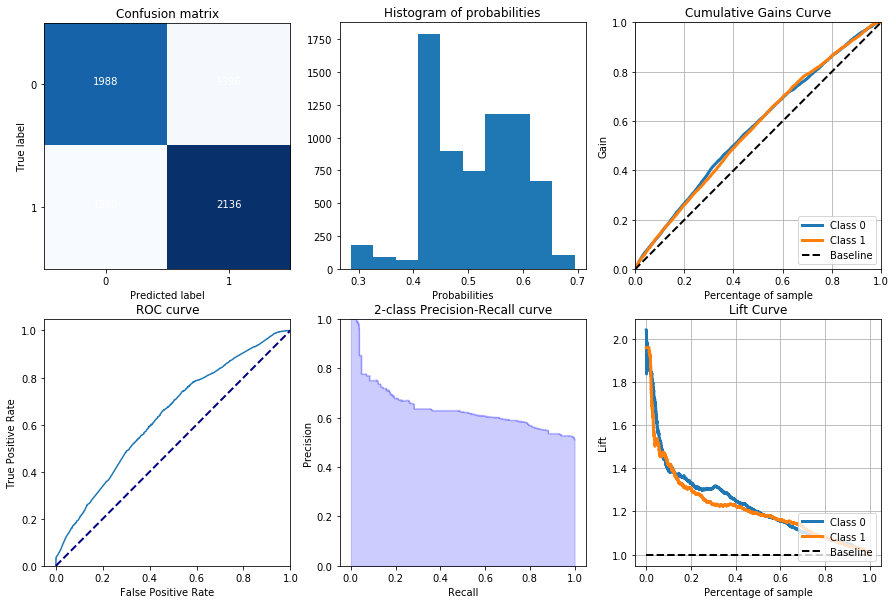

In [24]:
boost = xgb.XGBClassifier(learning_rate=0.02)

boost_model, _ = evaluate_clf(boost, X_train, y_train, X_val, y_val)

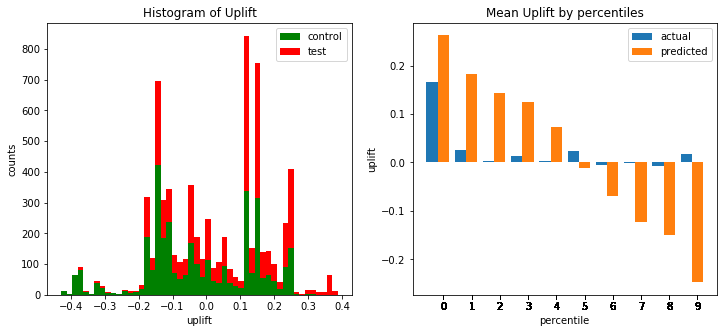

In [25]:
evaluate = Xy_val.copy()
evaluate = evaluate.assign(uplift=(2*(boost_model.predict_proba(X_val)[:,1]) - 1))

evaluate['predict'] = np.floor(evaluate.uplift.rank(method='first', ascending = False) /\
                                            (evaluate.shape[0]+1) * 10)

eval_actual = pd.crosstab(index=evaluate['predict'].astype(int), columns=evaluate['CONTROL_GROUP_FLG'], 
            values=evaluate['TARGET'], aggfunc='mean')
eval_actual['uplift'] = eval_actual[0] - eval_actual[1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].title.set_text('Histogram of Uplift')
axes[0].hist([evaluate[evaluate['CONTROL_GROUP_FLG']==0]['uplift'],
          evaluate[evaluate['CONTROL_GROUP_FLG']==1]['uplift']],
         stacked=True, label=['control', 'test'], bins=50, color=['g', 'r'])
axes[0].set_xlabel('uplift')
axes[0].set_ylabel('counts')
axes[0].legend()


axes[1].bar(eval_actual.index-0.4, eval_actual['uplift'], label='actual', width = 0.4)
axes[1].bar(evaluate.groupby('predict').mean().index, 
        evaluate.groupby('predict').mean()['uplift'], label='predicted', width=0.4)
axes[1].set_xticks(evaluate['predict'])
axes[1].set_xlabel('percentile')
axes[1].set_ylabel('uplift')
axes[1].legend()
axes[1].title.set_text('Mean Uplift by percentiles')

In [26]:
eval_actual

CONTROL_GROUP_FLG,0,1,uplift
predict,,,
0,0.193548,0.027426,0.166122
1,0.058394,0.033573,0.024821
2,0.016287,0.013021,0.003266
3,0.018315,0.004785,0.013530
4,0.052795,0.048780,0.004015
5,0.074405,0.050704,0.023701
6,0.044077,0.048780,-0.004703
7,0.027460,0.027559,-0.000099
8,0.011682,0.019011,-0.007329


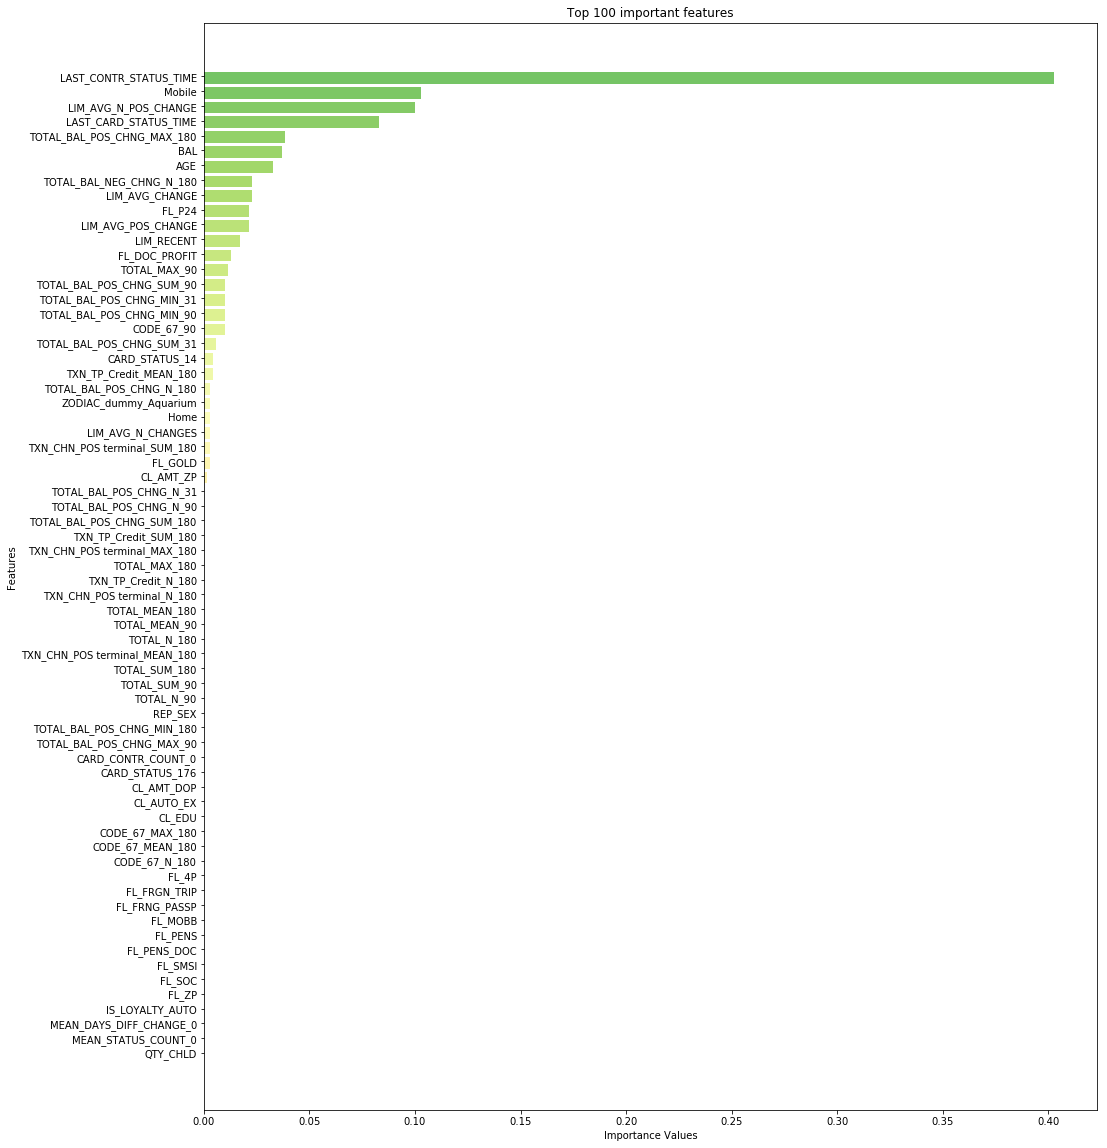

In [27]:
importances = pd.DataFrame(data={
    'features': X_train.columns,
    'fscore': boost_model.feature_importances_
})

# сортируем по абсолютному значению поля fscore
importances = importances.reindex(importances.fscore.abs().sort_values().index)

f_names, f_values = importances['features'].tail(100), importances['fscore'].tail(100)
## all columns from [st_idx : end_idx] will be plotted
## the higher the index, the more important the feature
st_idx = int(len(f_names) / 3); end_idx = int(len(f_names) / 1);

fig = plt.figure(figsize=(16, 20))
plt.barh(np.arange(len(f_names[st_idx : end_idx])), f_values[st_idx : end_idx],
         color=[cm.RdYlGn(i * 3) for i in range(len(f_names[st_idx : end_idx]))])
fig.axes[0].set_yticklabels(f_names[st_idx : end_idx])
fig.axes[0].set_yticks(np.arange(len(f_names[st_idx : end_idx])) + 0.1)
fig.axes[0].set_xlabel('Importance Values')
fig.axes[0].set_ylabel('Features')
fig.axes[0].set_label('Feature Importances')

plt.title('Top 100 important features')
plt.show()

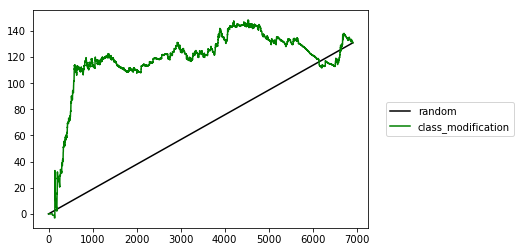

In [28]:
class_m_uc = uplift(evaluate, 'CONTROL_GROUP_FLG', 'TARGET', 'uplift')

rd_uc = (evaluate[evaluate['CONTROL_GROUP_FLG']==0]['TARGET'].sum() / evaluate[evaluate['CONTROL_GROUP_FLG']==0].shape[0]
        - evaluate[evaluate['CONTROL_GROUP_FLG']==1]['TARGET'].sum() / evaluate[evaluate['CONTROL_GROUP_FLG']==1].shape[0])
rd = np.arange(evaluate.shape[0]) * rd_uc

plt.plot(np.arange(evaluate.shape[0]), rd, color = 'k', label = 'random')
plt.plot(np.arange(evaluate.shape[0]), class_m_uc, color = 'g', label = 'class_modification')
plt.legend(bbox_to_anchor=(1.45, 0.6))